In [1]:
import numpy as np

In [2]:
qtrn = np.genfromtxt('data/DKI_data/qtrn.csv', delimiter=',')
qtst = np.genfromtxt('data/DKI_data/qtst.csv', delimiter=',')

In [25]:
print(qtrn.shape)
print(qtst.shape)

(500, 100)
(25000, 100)


<Axes: >

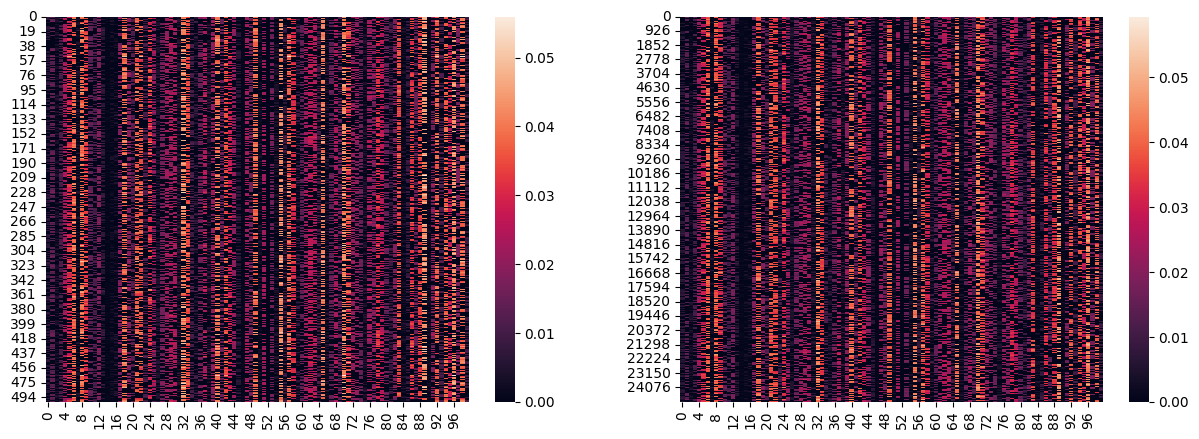

In [92]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(qtrn, ax=ax1)
sns.heatmap(qtst, ax=ax2)


In [91]:
(qtrn == qtrn).all()

True

In [1]:
from keystone.model import Net
from main import train
from types import SimpleNamespace

In [22]:
training_params = SimpleNamespace(
        file_path = './data/DKI_data/Ptrain.csv',
        batch_size = 16,
        test_size = 0.0,
        lr = 1e-3,
        epochs = 1000,
        verbosity = 10,
        layers = [100, 100]
    )

In [23]:
train(training_params)

Epoch: 0 	Training Loss: 1.82e-04 	Validation Loss: nan
Epoch: 10 	Training Loss: 7.66e-06 	Validation Loss: nan
Epoch: 20 	Training Loss: 2.82e-06 	Validation Loss: nan
Epoch: 30 	Training Loss: 2.16e-06 	Validation Loss: nan
Epoch: 40 	Training Loss: 1.95e-06 	Validation Loss: nan
Epoch: 50 	Training Loss: 1.79e-06 	Validation Loss: nan
Epoch: 60 	Training Loss: 1.72e-06 	Validation Loss: nan
Epoch: 70 	Training Loss: 1.66e-06 	Validation Loss: nan
Epoch: 80 	Training Loss: 1.64e-06 	Validation Loss: nan
Epoch: 90 	Training Loss: 1.62e-06 	Validation Loss: nan
Epoch: 100 	Training Loss: 1.61e-06 	Validation Loss: nan
Epoch: 110 	Training Loss: 1.60e-06 	Validation Loss: nan
Epoch: 120 	Training Loss: 1.60e-06 	Validation Loss: nan
Epoch: 130 	Training Loss: 1.58e-06 	Validation Loss: nan
Epoch: 140 	Training Loss: 1.57e-06 	Validation Loss: nan
Epoch: 150 	Training Loss: 1.56e-06 	Validation Loss: nan
Epoch: 160 	Training Loss: 1.56e-06 	Validation Loss: nan
Epoch: 170 	Training Loss

In [24]:
import torch
losses = torch.load('simple_net_loss.pt')
losses.keys()

dict_keys(['train', 'val'])

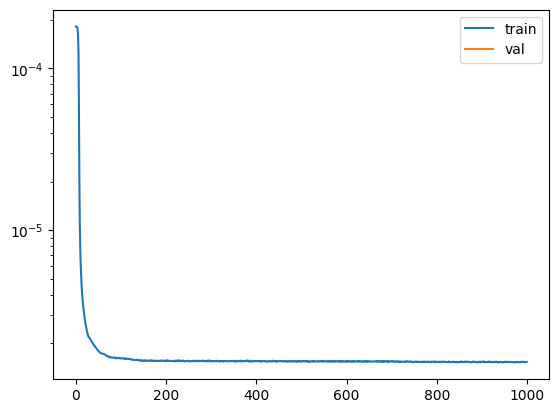

In [25]:
import matplotlib.pyplot as plt
plt.semilogy(losses['train'], label='train')
plt.semilogy(losses['val'], label='val')

plt.legend()

In [28]:
import torch

state_dict = torch.load('./simple_net.pt')

net = Net(100, 100, layers=[100, 100])

net.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
from keystone.keystone import calculate_keystone_array

In [30]:
from keystone.data_loading import process_data

X, Y = process_data('./data/DKI_data/Ptrain.csv')
X.shape

(500, 100)

In [31]:
# send an example through the network
example = X[0]
example = torch.tensor(example).float()
example = example.unsqueeze(0)
out = net(example).detach().numpy()

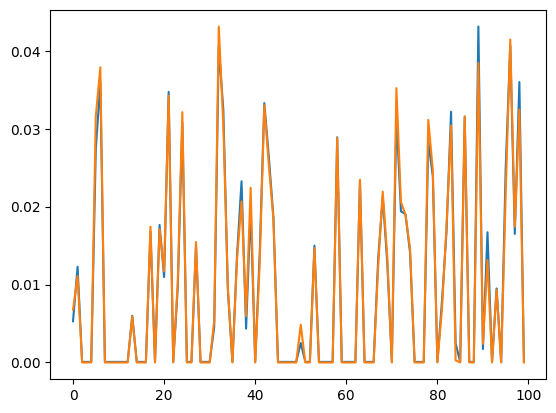

In [32]:
import matplotlib.pyplot as plt

plt.plot(out[0])
plt.plot(Y[0])

In [33]:
K = calculate_keystone_array(X, Y, net)

100%|██████████| 500/500 [00:02<00:00, 247.97it/s]


In [34]:
import numpy as np
DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]

In [35]:
DKI_keystone.shape

(25000, 6)

<Axes: >

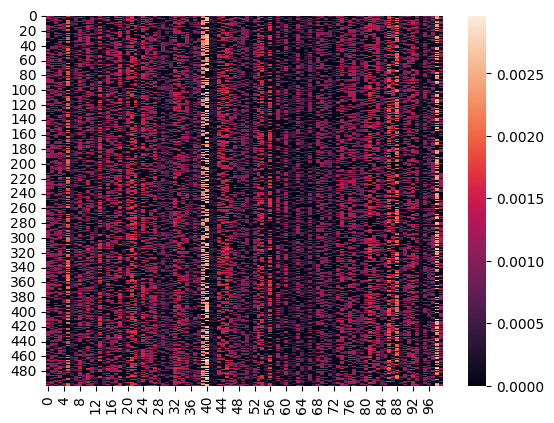

In [36]:
import seaborn as sns
sns.heatmap(K)


In [37]:
# get indices of all non-zero elements
import numpy as np
indices = np.where(K.T != 0)
indices

(array([ 0,  0,  0, ..., 99, 99, 99]),
 array([  0,   1,   2, ..., 494, 498, 499]))

In [38]:
# get only the non-zero elements of K and the corresponding indices in an array where each row is (i, j, K[i,j])
import numpy as np
DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]

non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])

my_keystones = dataframe["K[i,j]"].values
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

In [39]:
# save as csv
np.savetxt('keystoness.csv', non_zero, delimiter=',', header='i,j,K[i,j]')

In [40]:
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
dataframe.tail(20)

,i,j,"K[i,j]"
24980,100.0,459.0,0.001120
24981,100.0,461.0,0.001191
24982,100.0,462.0,0.001122
24983,100.0,463.0,0.001236
24984,100.0,467.0,0.001328
24985,100.0,468.0,0.001097
24986,100.0,470.0,0.001216
24987,100.0,471.0,0.001153
24988,100.0,473.0,0.001076
24989,100.0,474.0,0.001246


In [41]:
#extract j column only
j = dataframe['j'].values
other_js = DKI_keystone[:,5]
other_js

array([  1.,   2.,   3., ..., 495., 499., 500.])

Text(0.5, 1.0, 'Ours')

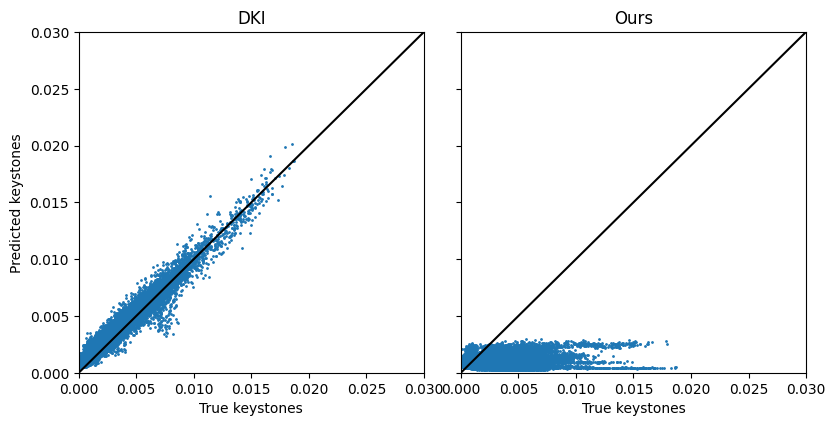

In [43]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
# plot diagonal line
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

In [36]:
DKI_keystone_pred = DKI_keystone[:,0]
DKI_keystone_true = DKI_keystone[:,2]

In [37]:
DKI_keystone_pred.shape

(25000,)

<Axes: >

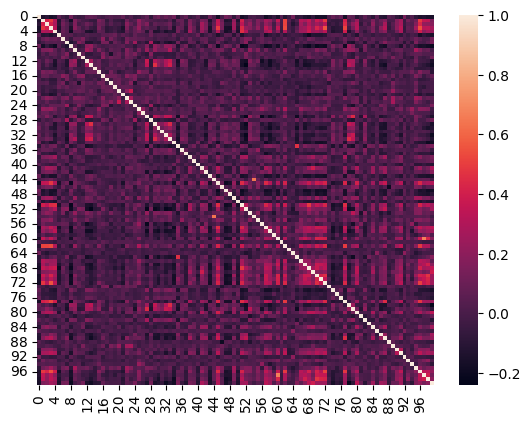

In [17]:
import seaborn as sns

sns.heatmap(data[:100,:100])

# Testing the ODEFunc Model

In [1]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchdiffeq import odeint
import torch
import matplotlib.pyplot as plt

from keystone.data_loading import process_data
import numpy as np
from tqdm import tqdm

In [2]:
def get_batch(ztrn,ptrn,mb_size):
    s = torch.from_numpy(np.random.choice(np.arange(ptrn.size(dim=0), dtype=np.int64), mb_size, replace=False))
    batch_p = ztrn[s,:]
    batch_q = ptrn[s,:]
    batch_t = t[:batch_time]
    batch_t = batch_t.astype(np.float32)
    return batch_p.to(device), batch_q.to(device),batch_t.to(device)

def loss_bc(p_i,q_i):
    return torch.sum(torch.abs(p_i-q_i))/torch.sum(torch.abs(p_i+q_i))

class ODEFunc(torch.nn.Module):
    def __init__(self, N):
        super(ODEFunc, self).__init__()
        self.fcc1 = torch.nn.Linear(N, N)
        self.fcc2 = torch.nn.Linear(N, N)

    def forward(self, t, y):
        out = self.fcc1(y)
        out = self.fcc2(out)
        f = torch.matmul(torch.matmul(torch.ones(y.size(dim=1),1),y),torch.transpose(out,0,1))
        return torch.mul(y,out-torch.transpose(f,0,1))

In [3]:
def process_data(P):
    Z = P.copy()
    Z[Z>0] = 1
    P = P/P.sum(axis=0)[np.newaxis,:]
    Z = Z/Z.sum(axis=0)[np.newaxis,:]
    
    P = P.astype(np.float32)
    Z = Z.astype(np.float32)

    P = torch.from_numpy(P.T)
    Z = torch.from_numpy(Z.T)
    return P,Z

In [4]:
P = np.loadtxt('./data/DKI_data/Ptrain.csv',delimiter=',')
ptrn, ztrn = process_data(P)

In [7]:
loss_train = []
loss_val = []

device = 'mps'

In [8]:
func = ODEFunc(P.shape[0]).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-2)

In [9]:
batch_time = 100
t = torch.arange(0.0, batch_time, 0.01)
mb = 20
N = 100
batch_p, batch_q, batch_t = get_batch(ztrn, ptrn, mb)
max_epochs = 1000

In [10]:
mb = 20
Loss_opt = 1
for e in tqdm(range(max_epochs)):
    optimizer.zero_grad()
    batch_p, batch_q, batch_t = get_batch(ztrn, ptrn, mb)

    for i in range(mb):
        p_pred = odeint(func,batch_p[i].unsqueeze(dim=0),batch_t).to(device)
        p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
        if i==0:
            loss = loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
        else:
            loss = loss + loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
    loss_train.append(loss.item()/mb)

    func.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [9]:
# run a single example through the network
batch_p, batch_q, batch_t = get_batch(ztrn, ptrn, 1)

p_pred = odeint(func,batch_p[0].unsqueeze(dim=0),batch_t).to(device)

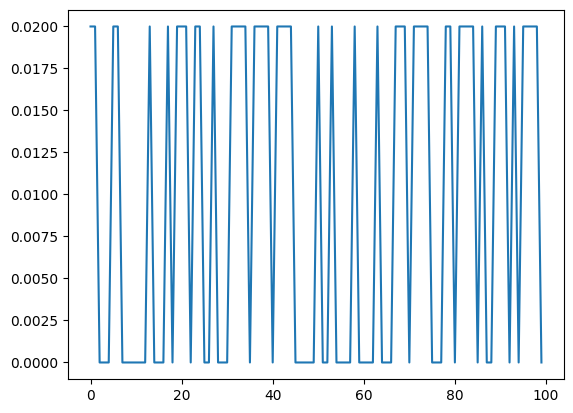

In [10]:
plt.plot(ztrn[0])

In [11]:
from scipy.spatial import distance

In [12]:
ptrn.shape

torch.Size([500, 100])

In [13]:
from tqdm import tqdm

K = np.zeros((ptrn.shape[0], ptrn.shape[1]))
for i, sample in enumerate(tqdm(ztrn)):

    with torch.no_grad():
        abundances = odeint(func,sample.unsqueeze(dim=0),batch_t).to(device)[-1,0,:].detach().numpy()
        
    for j in range(len(abundances)):
        p = abundances[j]

        if p == 0:
            k = 0

        else:
            abundances_copy = abundances.copy()
            abundances_copy[j] = 0
            # normalize abundances to sum to 1
            null_abundance = abundances_copy/abundances_copy.sum()

            sample_copy = sample.clone()
            sample_copy[j] = 0

            with torch.no_grad():
                predicted_abundance = odeint(func,sample_copy.unsqueeze(dim=0),batch_t).to(device)[-1,0,:].detach().numpy()

            k = distance.braycurtis(predicted_abundance, null_abundance) * (1 - p)
        K[i,j] = k
    

100%|██████████| 500/500 [03:42<00:00,  2.25it/s]


<Axes: >

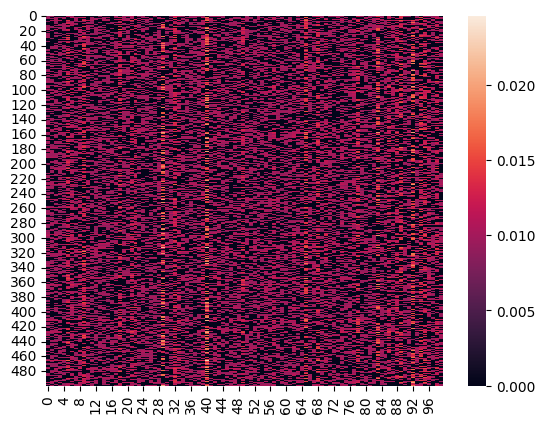

In [14]:
import seaborn as sns
sns.heatmap(K)

In [16]:
import numpy as np
indices = np.where(K.T != 0)

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]

non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])

my_keystones = dataframe["K[i,j]"].values
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

Text(0.5, 1.0, 'Ours')

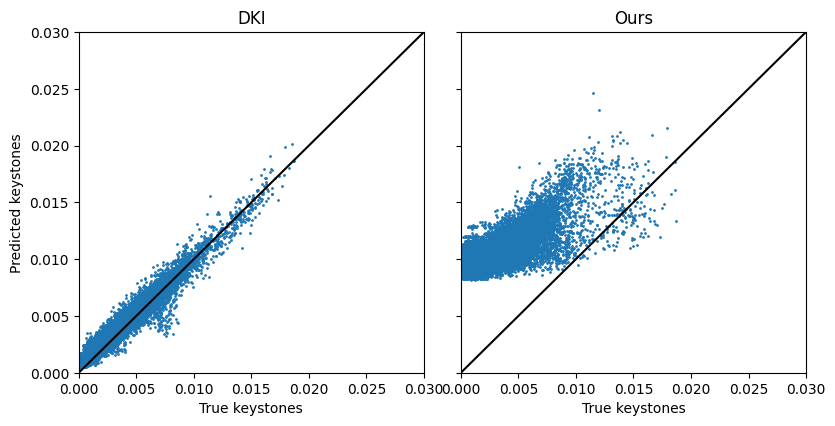

In [17]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
# plot diagonal line
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

In [ ]:
import numpy as np
import torch
from scipy.spatial import distance
from tqdm import tqdm


def calculate_keystone(j, sample, original_abundance, model):
    # if the abundance is already zero, then the keystone index is zero
    p = original_abundance[j]

    if p == 0:
        return 0

    with torch.no_grad():
        new_abundance = model(torch.tensor(sample.reshape(1, -1), dtype=torch.float32)).numpy().flatten()

    new_sample = sample.copy()

    new_sample[j] = 0
    new_abundance[j] = 0

    null_abundance = new_abundance / new_abundance.sum()

    with torch.no_grad():
        predicted_abundance = model(torch.tensor(new_sample.reshape(1, -1), dtype=torch.float32)).numpy()
    
    k = distance.braycurtis(null_abundance, predicted_abundance.flatten()) * (1 - p)

    return k



def calculate_keystone_array(sample_array, sample_abundances, model):
    K = np.zeros((sample_array.shape[0], sample_array.shape[1]))

    for i, sample in enumerate(tqdm(sample_array)):
        original_abundance = sample_abundances[i]
        for j, _ in enumerate(sample):
            K[i, j] = calculate_keystone(j, sample, original_abundance, model)
            
    return K